# Correction Factor from Density Matches
This script creates a merged table from matching density between the Winkler logs datafile and the CTD files. Then, the ratio between Winkler O2 values to the CTD O2 values is used to correct the CTD O2 files. 

In [1]:
# Let's find the linear regression for all stations: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import colorcet as ccmport 
import seaborn as sns
import colorcet as cc
# Get CSV files list from a folder
path ='/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/Log'
csv_files = glob.glob(path + "/*.csv")

# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
stations_df = pd.concat(df_list)

#Create a bottle file with all winkler values and other parameters measured when sampling:
#stations_df.to_csv('bottlefile_hly2202.csv')

#Calculating potential density for each bottle sample drawn:
stations_df['sigma-theta']= stations_df['Sigma']*1000 - 1000
stations_df = stations_df.dropna(subset = ['Winkler umol/kg'])

#Import required packages:
import matplotlib.pyplot as plt
from pathlib import Path

#Define path name for pre ctd files#
#path1 = Path("/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/CTD_Northbound/")
#csv_files1 = path1.glob("*Pre1dbar.cnv")

#import pre ctd files
#pre_list = [pd.read_csv(file, encoding="ISO-8859-1", delim_whitespace=True, skiprows=319, header=None)
              # .assign(filename=file.stem.split("_")[1]) for file in csv_files1]
#pre_df = pd.concat(pre_list) #concat pre ctd files

#Define path name for post ctd files/Northbound
path2 = Path("/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/CTD_Northbound")
csv_files2 = path2.glob("*Pcaldown1dbar.cnv")

#import post Northbound ctd files
postnorth_list = [pd.read_csv(file2, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(filename=file2.stem.split("_")[1]) for file2 in csv_files2]

postnorth_df = pd.concat(postnorth_list) #concat post northbound ctd files

#Define path name for post ctd files/Southbound
path3 = Path("/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/CTD_Southbound")
csv_files3 = path3.glob("*Pcaldown1dbar.cnv")

#import post Southbound ctd files
postsouth_list = [pd.read_csv(file3, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(filename=file3.stem.split("_")[1]) for file3 in csv_files3]

postsouth_df = pd.concat(postsouth_list) #concat post southbound ctd files

# Concatenate all DataFrames
all_df = pd.concat([postnorth_df, postsouth_df])

import gsw
from gsw_gammat_analytic_CT_exact import gsw_gammat_analytic_CT_exact

#Calculate Reference Composition Salinity and Conservative Temperature

all_df['SA'] = gsw.SA_from_SP(all_df[4], all_df[0],all_df[20],all_df[19]) 
#Calculating Conservative Temperature from potential temperature
all_df['theta'] = gsw.pt0_from_t(all_df['SA'],all_df[2],all_df[0])
all_df['CT'] = gsw.conversions.CT_from_pt(all_df['SA'],all_df['theta']) #conservative temperature ITS-90
#Calculate gamma_T Tailleux routine:
all_df['gammat_teos10'],all_df['zref_teos10'],all_df['pref_teos10'],all_df['sigref_teos10'] = gsw_gammat_analytic_CT_exact(all_df['SA'],all_df['CT'])

#For winkler values:

#stations_df['SA'] = gsw.SA_from_SP(stations_df['Sal00'], stations_df['PrDM'],stations_df['Longitude'],stations_df['Latitude']) 
#stations_df['theta'] = gsw.pt0_from_t(stations_df['SA'],stations_df['T090C'],stations_df['PrDM'])
#stations_df['CT'] = gsw.conversions.CT_from_pt(stations_df['SA'],stations_df['theta']) #conservative temperature ITS-90
#stations_df['gammat_teos10'],stations_df['zref_teos10'],stations_df['pref_teos10'],stations_df['sigref_teos10'] = gsw_gammat_analytic_CT_exact(stations_df['SA'],stations_df['CT'])

In [2]:
#Creating a new dataframe with matched values 
all_df.rename(columns={'filename':'Cast'}, inplace=True)
#Converting into numerical int64 values: 
all_df['gammat_teos10'] = all_df['gammat_teos10'].round(3)
all_df['Cast'] = all_df['Cast'].astype(np.int64)
stations_df['Cast'] = stations_df['Cast'].astype(np.int64)
stations_df['Cast'] = stations_df['Cast'].round(3)
#belowall = all_df.loc[(all_df[0] >=100) ]
#below = stations_df.loc[(stations_df['PrDM'] >= 100) ]

d1 = stations_df.sort_values('sigma-theta', ascending=True)
d2 = all_df.sort_values('gammat_teos10', ascending=True)
#d1 = stations_df.sort_values('sigma-theta', ascending=True)
#d2 = all_df.sort_values('gammat_teos10', ascending=True)

#merged_df = pd.merge_asof(d1,d2,left_on= 'sigma-theta',right_on= 'gammat_teos10', by='Cast',direction='nearest')
#econd_df = merged_df.dropna(subset='Niskin'
#merged_df['CF'] = merged_df['Winkler umol/kg']/merged_df[16]
#merged_df = merged_df.dropna(subset=['CF'])
#print (merged_df['CF'].mean())

In [3]:

x = pd.merge_asof(d2, d1, left_on='gammat_teos10', right_on='sigma-theta',
              allow_exact_matches=True,
              direction='nearest')

test = d1.merge(x, how='left', right_on='Cast_y', left_on='Cast')
#df = pd.DataFrame(test[test.index_x==test.index_y]['Cast'], columns=['Cast']).reset_index(drop=True)

In [4]:
test = test.drop_duplicates(subset=['Winkler umol/kg_y','Winkler umol/kg_y'], keep='first')

In [5]:
test['CF'] = test['Winkler umol/kg_y']/test[16]
test = test.dropna(subset=['CF'])
test['CF'].mean()

1.0379805051855164

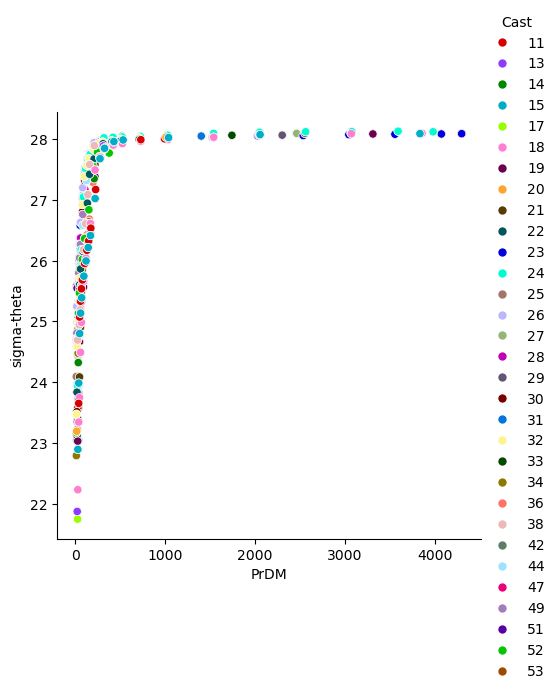

In [33]:
#custom_palette = sns.color_palette("viridis", 29)
palette = sns.color_palette(cc.glasbey, n_colors=31)

sns.relplot(x='PrDM',
            y='sigma-theta',
            data=stations_df,
            kind='scatter',
            legend='full', hue='Cast', palette=palette)
#plt.axhline(y=1.03798, color='r', linestyle='-')

plt.show()

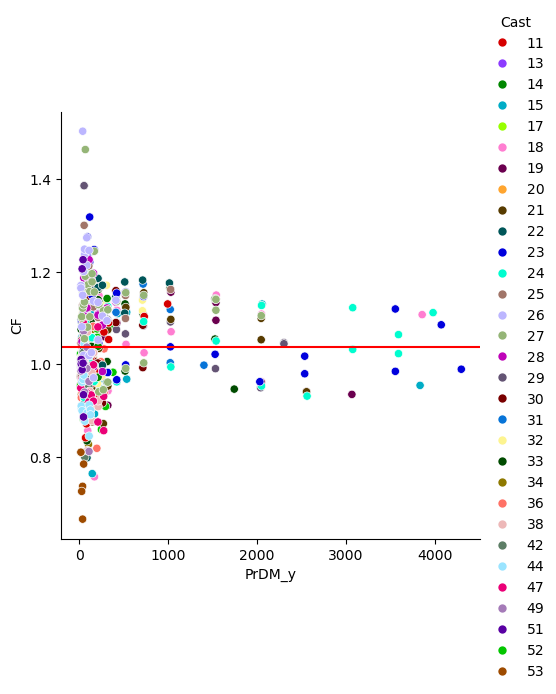

In [55]:
#custom_palette = sns.color_palette("viridis", 29)
palette = sns.color_palette(cc.glasbey, n_colors=31)

sns.relplot(x='PrDM_y',
            y='CF',
            data=test,
            kind='scatter',
            legend='full', hue='Cast', palette=palette)
plt.axhline(y=1.03798, color='r', linestyle='-')

plt.show()

In [30]:
from scipy import stats
stddev_3 = test[np.abs(stats.zscore(test['CF'])) < 3]

from scipy import stats
stddev_2 = test[np.abs(stats.zscore(test['CF'])) < 2]


stddev_2['CF'].mean(), stddev_3['CF'].mean()

(1.0383226688890603, 1.0364431937967264)

In [36]:
print(test['CF'].quantile(0.10))
print(test['CF'].quantile(0.90))
quantile = test.loc[(test['CF'] >= 0.9203) & (test['CF'] <= 1.16225)]
quantile['CF'].mean()

0.9203081749793055
1.1622572815905852


1.0377771582108979

In [37]:
#Deciding to work with 99.7% confidence interval

#Creating different blocks
block1 = quantile.loc[(quantile['Cast_x'] >=10) & (quantile['Cast_x'] <=23)]
block2 = quantile.loc[(quantile['Cast_x'] >=23) & (quantile['Cast_x'] <=54)]
#postctd = quantile.loc[(quantile['Cast'] >=10) & (quantile['Cast'] <=54)]

#Calculating CF for each block
mean1 = block1['CF'].mean()
mean2 = block2['CF'].mean()
#mean3 = quantile['CF'].mean()
block2['CF'].mean(), block1['CF'].mean()

(1.037177693713317, 1.0378626332611733)

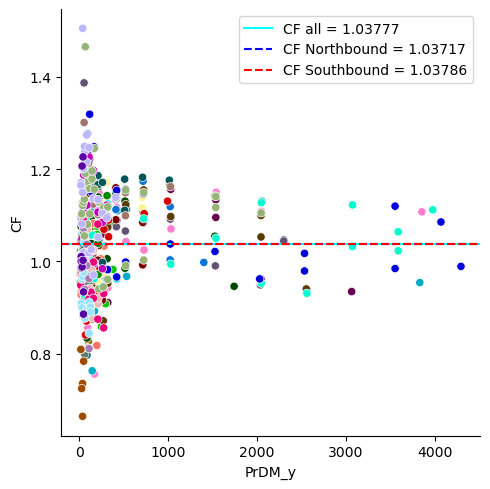

In [41]:
palette = sns.color_palette(cc.glasbey, n_colors=31)

sns.relplot(x='PrDM_y',
            y='CF',
            data=test,
            kind='scatter',
            legend=False,
            hue='Cast', palette=palette)
plt.axhline(y=1.03777, color='cyan', linestyle='-',label='CF all = 1.03777')
plt.axhline(y=1.03717, color='b', linestyle='dashed', label='CF Northbound = 1.03717')
plt.axhline(y=1.03786, color='r', linestyle='dashed', label='CF Southbound = 1.03786')
#plt.axhline(y=1.022251, color='g', linestyle='dotted')

plt.legend()
plt.show()

In [56]:
s = pd.Series(data= [1.03777, 1.03717, 1.03786])
print (s.std())


0.0003750999866702839


# Compare with Canadian Cruise

NMEA Latitude = 78 00.31 N
NMEA Longitude = 149 59.87 W

#StLau
* NMEA Latitude = 78 00.65 N
* NMEA Longitude = 149 59.35 W

Text(0.5, 1.0, 'Station 15')

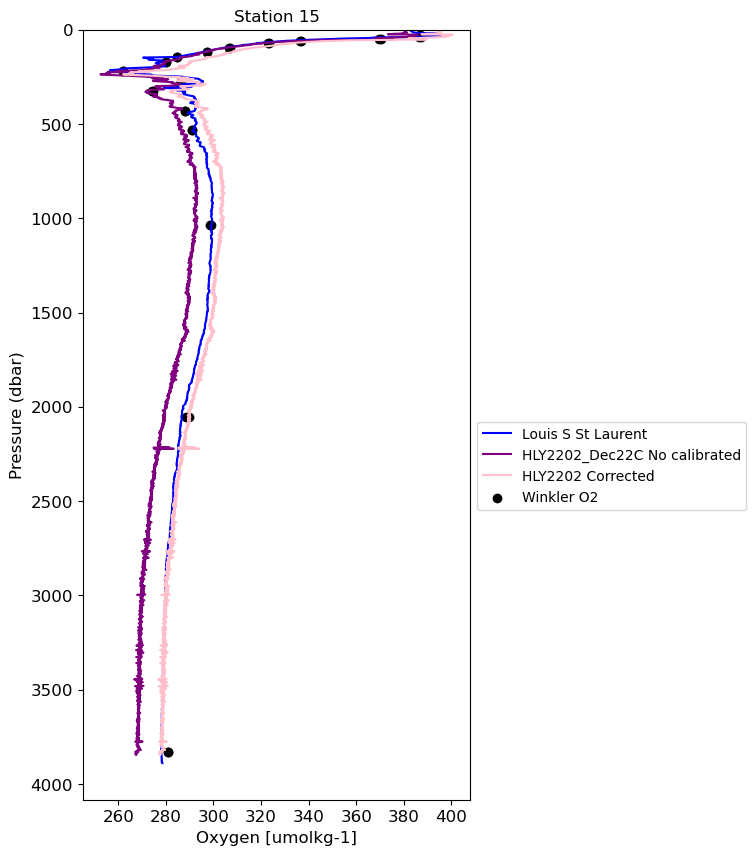

In [35]:
all_df['O2_correct']= all_df[16]*1.037777
station15  = all_df.loc[all_df['Cast'] == 15]

compare = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/d2022-045-0022.cnv', encoding="ISO-8859-1", delim_whitespace=True, skiprows=569, header=None)
compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
compare['sigma-den'] = compare['density-rho'] - 1000
oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)
# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(oxy,compare[1],color='blue', markersize=0.5, label= 'Louis S St Laurent')
plt.plot(station15[16],station15[0],color='purple', markersize=0.1, label= 'HLY2202_Dec22C No calibrated')
plt.plot(station15['O2_correct'],station15[0],color='pink', markersize=0.1, label= 'HLY2202 Corrected')
#plt.plot(station15['CFO2_above500'],station15[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station15['CFO2_below500'],station15[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
station15_W  = stations_df.loc[stations_df['Cast'] == 15]
plt.scatter(station15_W['Winkler umol/kg'],station15_W['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Station 15')

# Create a Boxplot for distribution of data

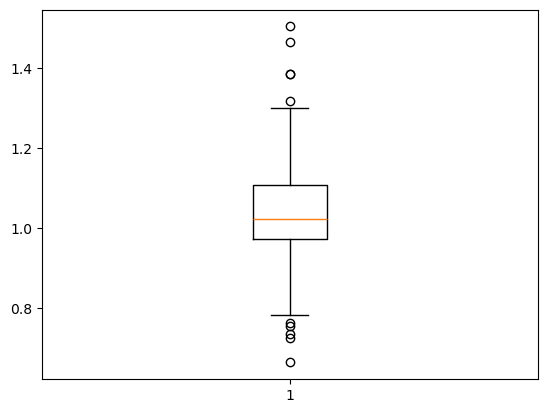

In [34]:
plt.boxplot(test["CF"])
plt.show()

Text(0.5, 1.0, 'North Pole')

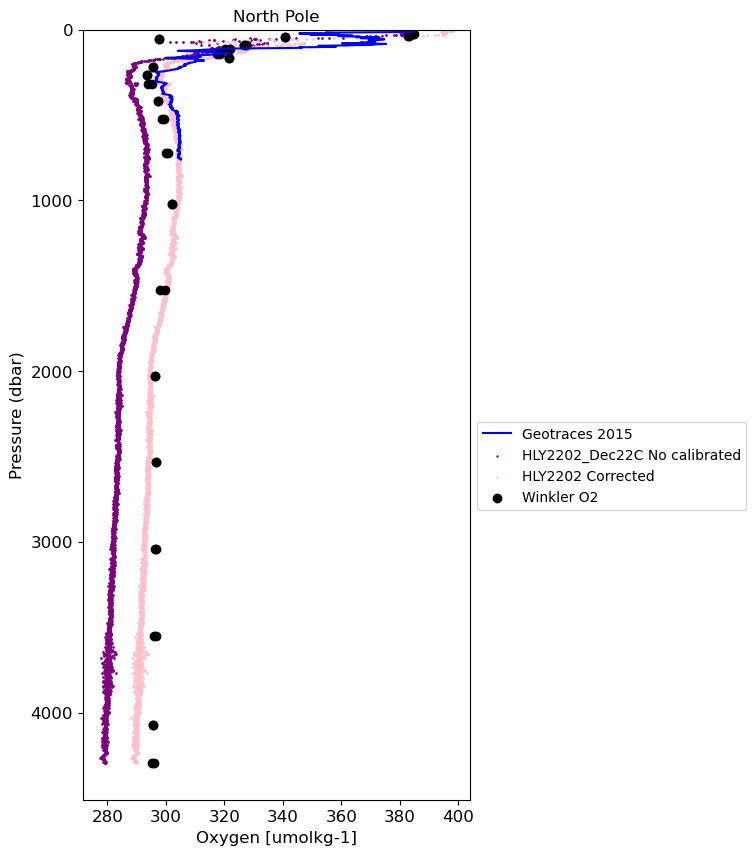

In [43]:
#Selecting only CTD North Pole Cast
station23  = all_df.loc[all_df['Cast'] == 23]
import xarray as xr
geo_lat90 = xr.open_dataset('/Users/mariacristinaalvarez/Documents/NorthPoleO2/Geotraces2015/East/33HQ20150809_00032_00004_ctd.nc')
#Calculate SA, CT #Can't calculate, file does not contain density, latitude and longitude t caculate TEOS-10
#compare['SA'] = gsw.SA_from_SP(compare[4], compare[1],compare[20],compare[19]) 
#compare['CT'] = gsw.conversions.CT_from_pt(compare['SA'],compare[20]) #conservative temperature ITS-90
#Calculate in-situ density and sigma theta

#Will use EOS-80 for this purposes
#compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
#compare['sigma-den'] = compare['density-rho'] - 1000

#oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)

#Selecting Winkler values from station 15
#merged_sigma['Cast'] = pd.to_numeric(merged_sigma['Cast'])
Winkler_S23 = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/Log/HEALY2202_S21C23.csv')

# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(geo_lat90.oxygen,geo_lat90.pressure,color='blue', markersize=0.5, label= 'Geotraces 2015')
plt.scatter(station23[16],station23[0],color='purple', s= 0.5,label= 'HLY2202_Dec22C No calibrated')
plt.scatter(station23['O2_correct'],station23[0],color='pink', s= 0.5,label= 'HLY2202 Corrected')
#plt.plot(station23['CFO2_above500'],station23[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station23['CFO2_below500'],station23[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
plt.scatter(Winkler_S23['Winkler umol/kg'],Winkler_S23['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('North Pole')

Contour Plots!

# Creating a single contour Plot 

/var/folders/2b/pwxn7kh9125g4k207h_wmc8h0000gn/T/ipykernel_98717/3640225997.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northbound['O2_Correct']= northbound[16]*1.04434
/var/folders/2b/pwxn7kh9125g4k207h_wmc8h0000gn/T/ipykernel_98717/3640225997.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northbound[19] = northbound[19].round(decimals=0)


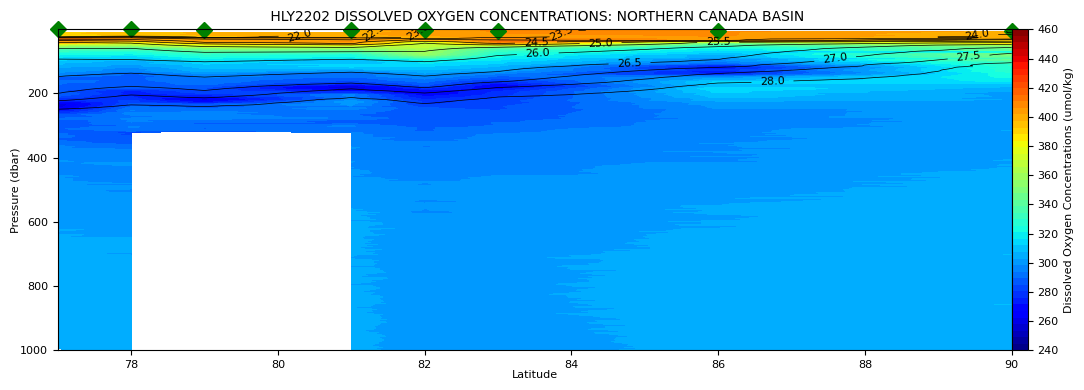

In [6]:
#Northbound selection, correct O2 values. CF(stddev3)
#
northbound = all_df.loc[(all_df['Cast'] >=10) & (all_df['Cast'] <=23)]
northbound['O2_Correct']= northbound[16]*1.04434

northbound[19] = northbound[19].round(decimals=0)
northbound = northbound.sort_index().interpolate(method='linear', limit_area='inside')
pivot_df = northbound.pivot_table(index=0, columns = 19, values='O2_Correct')

depth2 = pivot_df.index
lati2 = pivot_df.columns
oxygen2 = pivot_df.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(12,4))
levels = np.linspace(240, 460)
plt.contourf(xi,yi,oxygen2, cmap = 'jet', levels=levels,vmin=240, vmax=460)
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

cbar = plt.colorbar(ticks=(240,260,280,300,320, 340,360,380,400,420,440,460), pad=0)
cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=8)
cbar.ax.tick_params(labelsize=8)
plt.xlabel('Latitude',fontsize=8, labelpad=0)
plt.ylabel('Pressure (dbar)' ,fontsize=8, labelpad=0)
plt.ylim(bottom = 1000)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.plot(lati2,range(len(lati2)), 'gD',clip_on=False, markersize=8, zorder=1)

#plt.xlim(left = 80)
plt.title(" HLY2202 DISSOLVED OXYGEN CONCENTRATIONS: NORTHERN CANADA BASIN", fontsize=10)


##Creating matrix for density tables
density_df = northbound.pivot_table(index=0, columns = 19, values='gammat_teos10')
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')
#levels2 = np.linspace(24,28,4)
levels2 = (21, 21.5, 22, 22.5, 23, 23.5,24,24.5, 25,25.5)
levels3 = (26,26.5,27.0, 27.5, 28.0, 28.5, 29) 
density1 = plt.contour(Xi, Yi, density.T , levels = levels2,vmin=21,vmax=26, linestyles = '-', linewidths = 0.5, colors= 'black')
density2 = plt.contour(Xi, Yi, density.T ,levels=levels3, vmin=26, vmax=29, linestyles = '-', linewidths = 0.5, colors= 'black')
plt.clabel(density1, inline=1, fontsize=8)
plt.clabel(density2, inline=1, fontsize=8)
plt.tight_layout()

#plt.savefig("HLY2202_O2_NORTHERNCB.png",facecolor='white',transparent = False)

# Extract Bathymmetry Values!

NameError: name 'northbound' is not defined

In [8]:
#Northbound selection, correct O2 values. CF(stddev3)
all_df['O2_correct'] = all_df[16]*1.037777
northbound = all_df.loc[(all_df['Cast'] >=10) & (all_df['Cast'] <=23)]
southbound = all_df.loc[(all_df['Cast'] >=23) & (all_df['Cast'] <=54)]

#Pivot Table Northbound
northbound[19] = northbound[19].round(decimals=0)
northbound = northbound.sort_index().interpolate(method='linear', limit_area='inside')
pivot_df = northbound.pivot_table(index=0, columns = 19, values='O2_correct')
depth2 = pivot_df.index
lati2 = pivot_df.columns
oxygen2 = pivot_df.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
##Creating matrix for density tables
density_df = northbound.pivot_table(index=0, columns = 19, values='gammat_teos10')
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')

#Pivot Table Southbound
southbound[19] = southbound[19].round(decimals=0)
southbound = southbound.sort_index().interpolate(method='linear', limit_area='inside')
southpivot = southbound.pivot_table(index=0, columns = 19, values='O2_correct')
depth1 = southpivot.index
lati1 = southpivot.columns
oxygen1 = southpivot.values.transpose()
ai, bi = np.meshgrid(lati1,depth1,indexing='ij')

southdensity_df = southbound.pivot_table(index=0, columns = 19, values='gammat_teos10')
southdensity_df.dropna()
southdensity_df.drop(index=southdensity_df.index[0], axis=0, inplace=True)
depth = southdensity_df.index
lati = southdensity_df.columns
southdensity = southdensity_df.values
Ai,Bi = np.meshgrid(lati,depth, indexing='ij')





/var/folders/2b/pwxn7kh9125g4k207h_wmc8h0000gn/T/ipykernel_20715/3751135485.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northbound[19] = northbound[19].round(decimals=0)
/var/folders/2b/pwxn7kh9125g4k207h_wmc8h0000gn/T/ipykernel_20715/3751135485.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  southbound[19] = southbound[19].round(decimals=0)


In [12]:
import pygmt
import xarray
# define etopo data file
xds = xarray.load_dataset("/Users/mariacristinaalvarez/Documents/Documents/Projects/mapping_glodap/ETOPO1_Bed_g_gmt4.grd", decode_coords="all")
x= np.array(northbound[20])
y = np.array(northbound[19])

topo = xds.sel(y=y,x=x, method='nearest')
df = topo.to_dataframe()

df = df.reset_index()

bathy = pd.merge_asof(northbound, df, left_on=northbound[19].sort_values(ascending=True), right_on= df['y'].sort_values(ascending=True), direction='nearest')
bathypivot = bathy.pivot_table(index=0, columns = 19, values='z')

mi, ni = np.meshgrid(bathypivot.columns,bathypivot.index,indexing='ij')
bathypivot = bathypivot.interpolate(method='linear')

: 

In [11]:
bathypivot['key_0']

KeyError: 'key_0'

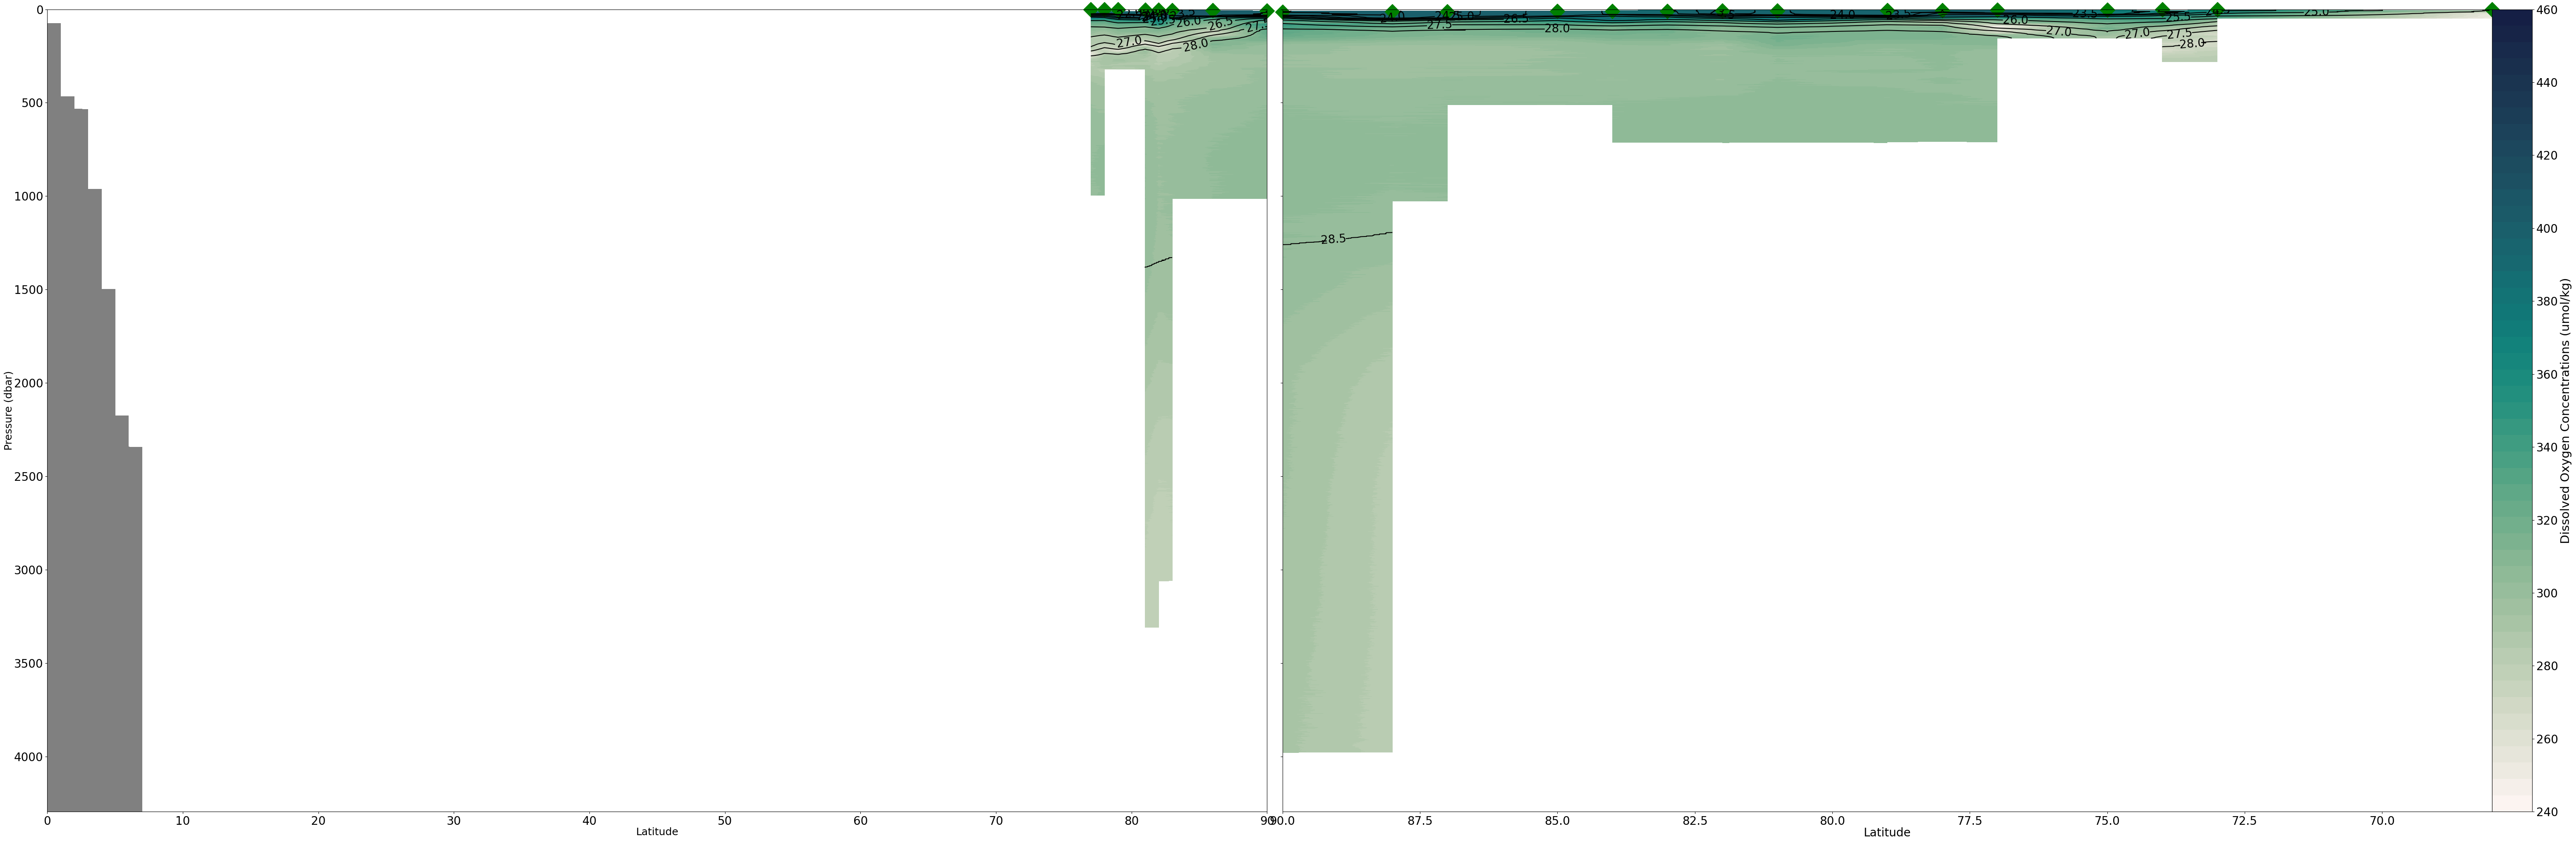

In [10]:
import cmocean
#Levels for O2 concentrations
levels = np.linspace(240, 460)
#Levels for Density
levels2 = (21, 21.5, 22, 22.5, 23, 23.5,24,24.5, 25,25.5)
levels3 = (26,26.5,27.0, 27.5, 28.0, 28.5, 29) 
#cmap = cmocean.cm.matter
cmap = cmocean.cm.tempo
#cmap = cmocean.cm.solar_r
#Create a grid for figure
fig, (ax1,ax2) = plt.subplots(1,2,figsize= (65,20), gridspec_kw={'width_ratios': [6, 7]},sharey=True)
fig.tight_layout() 
#Northound 
north = ax1.contourf(xi,yi,oxygen2, cmap = cmap, levels=levels,vmin=240, vmax=460)
ax1.contourf(bathypivot.values, colors = 'grey')
ax1.invert_yaxis()

#plt.gca().invert_xaxis()
lat = np.linspace(68,90, 12)
#press = (0,200,400,600,800,1000,2000,3000,4000)

#Set X, Y axis
ax1.set_xlabel('Latitude',fontsize=18, labelpad=0)
ax1.tick_params(axis="x", labelsize=20) 
ax1.set_ylabel('Pressure (dbar)' ,fontsize=18, labelpad=0)
ax1.tick_params(axis="y", labelsize=20) 
ax1.set_ylim(top= 0)

#Plotting Density lines
ax1.plot(lati2,range(len(lati2)), 'gD',clip_on=False, markersize=18, zorder=1)
density1 = ax1.contour(Xi, Yi, density.T , levels = levels2,vmin=21,vmax=26, linestyles = '-', linewidths = 1.5, colors= 'black')
density2 = ax1.contour(Xi, Yi, density.T ,levels=levels3, vmin=26, vmax=29, linestyles = '-', linewidths = 1.5, colors= 'black')
ax1.clabel(density1, inline=1, fontsize=20)
density2 = ax1.clabel(density2, inline=1, fontsize=20)

#Southbound
south = ax2.contourf(ai,bi,oxygen1, cmap = cmap, levels=levels,vmin=240, vmax=460)
#ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_xlabel('Latitude',fontsize=20, labelpad=0)
ax2.tick_params(axis="x", labelsize=20) 
#plt.ylim(top = 0, bottom = 2000)
#Plotting stations
ax2.plot(lati1,range(len(lati1)), 'gD',clip_on=False, markersize=18, zorder=1)
#Ploting Density Lines
density3 = ax2.contour(Ai, Bi, southdensity.T , levels = levels2,vmin=21,vmax=26, linestyles = '-', linewidths = 1.5, colors= 'black')
density4 = ax2.contour(Ai, Bi, southdensity.T ,levels=levels3, vmin=26, vmax=29, linestyles = '-', linewidths = 1.5, colors= 'black')
ax2.clabel(density3, inline=1, fontsize=20)
density4 = ax2.clabel(density4, inline=1, fontsize=20)

#Set Colorbar
bar = fig.colorbar(south,ticks=(240,260,280,300,320, 340,360,380,400,420,440,460), pad=0)
bar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=21)
bar.ax.tick_params(labelsize=20)

#plt.title(" HLY2202 DOC umol/kg", fontsize=18)
#plt.savefig('/Users/mariacristinaalvarez/Documents/Github/ArcticO2/Figures/ContourPlot.png', dpi = 70, bbox_inches = 'tight' , pad_inches = 0)

